# LLM Hallucination detection

## Imports

In [87]:
import os
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from lime.lime_text import LimeTextExplainer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Prepare and inspect data

In [40]:
df_raw = pd.read_csv('./data/train.csv')
df_clean = pd.read_csv('./data/train.csv')

In [41]:
print(df_clean.Target.value_counts())
print(df_clean.Target.value_counts(normalize=True))

Target
0    15793
1      894
Name: count, dtype: int64
Target
0    0.946425
1    0.053575
Name: proportion, dtype: float64


Only 5.36% of the data is hallucination data. So predicting "No hallucination" always, would score 94.64% on this data. Our model should perform better than that actually to be meaningful.

# Clean data
- lower case text
- remove words with digits
- drop empty values
- remove empty tokens
- remove stop words (TF-IDF)
- use only words appearing in at least five documents (TF-IDF)
- use only words appearing in less than 90% of the documents (TF-IDF)

This cleans the data and gives us fewer unique words to work with.

In [42]:
# count unique words before lowercasing and cleaning text
words = df_clean[['Prompt', 'Answer']].apply(lambda x: x.str.split()).stack().explode()
unique_words = words.unique()
print(f'Number of unique words in dataset before cleaning data: {len(unique_words)}')

Number of unique words in dataset before cleaning data: 188015


In [43]:
import re
def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r'\b[a-z]+\b', text)
    return " ".join(tokens)

In [45]:
df_clean = df_clean.dropna(subset=['Prompt', 'Answer'])
df_clean.info()

df_clean['Prompt_clean'] = df_clean['Prompt'].apply(preprocess_text)
df_clean['Answer_clean'] = df_clean['Answer'].apply(preprocess_text)

df_clean = df_clean[
    (df_clean['Prompt_clean'].str.strip() != '') &
    (df_clean['Answer_clean'].str.strip() != '')
].reset_index(drop=True)
df_clean.info()

<class 'pandas.DataFrame'>
Index: 16668 entries, 0 to 16686
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      16668 non-null  int64
 1   Prompt  16668 non-null  str  
 2   Answer  16668 non-null  str  
 3   Target  16668 non-null  int64
dtypes: int64(2), str(2)
memory usage: 20.1 MB
<class 'pandas.DataFrame'>
RangeIndex: 16195 entries, 0 to 16194
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Id            16195 non-null  int64
 1   Prompt        16195 non-null  str  
 2   Answer        16195 non-null  str  
 3   Target        16195 non-null  int64
 4   Prompt_clean  16195 non-null  str  
 5   Answer_clean  16195 non-null  str  
dtypes: int64(2), str(4)
memory usage: 37.6 MB


In [47]:
df_clean.Target.value_counts()

Target
0    15388
1      807
Name: count, dtype: int64

In [48]:
df_clean.head()

,Id,Prompt,Answer,Target,Prompt_clean,Answer_clean
0,11527,[INST] You are an AI assistant that helps peop...,Step-by-step reasoning process:\n1. Randy spen...,0,inst you are an ai assistant that helps people...,step by step reasoning process randy spends ev...
1,7322,[INST] You are an AI assistant. You will be gi...,What is the temperature at which hypothermia b...,0,inst you are an ai assistant you will be given...,what is the temperature at which hypothermia b...
2,11742,[INST] You are an AI assistant. You will be gi...,Answer: c) No. \n\nThe hypothesis is false bec...,0,inst you are an ai assistant you will be given...,answer c no the hypothesis is false because th...
3,20928,[INST] You are an AI assistant. User will you ...,Prismatoid,0,inst you are an ai assistant user will you giv...,prismatoid
4,25830,[INST] You are an AI assistant. User will you ...,Case B,0,inst you are an ai assistant user will you giv...,case b


In [9]:
# count unique words after lowercasing and cleaning text 
words_cleaned = df_clean[['Prompt_clean', 'Answer_clean']].apply(lambda x: x.str.split()).stack().explode()
unique_words_cleaned = words_cleaned.unique()
print(f'Number of unique words in dataset after cleaning data: {len(unique_words_cleaned)}')

Number of unique words in dataset after cleaning data: 64981


## Tokenization and stemming

- To further clean the input tokenization and removing of stopwords is applied

In [73]:
def features(df):
    df=df.copy()
    df = df.dropna(subset=['Prompt', 'Answer'])
    stops = stopwords.words('english')
    stemmer = PorterStemmer()
    
    # tokenize the texts
    df['Prompt_clean'] = df['Prompt_clean'].apply(lambda text: word_tokenize(text))
    df['Answer_clean'] = df['Answer_clean'].apply(lambda text: word_tokenize(text))
    # removing stopwords
    df['Prompt_clean'] = df['Prompt_clean'].apply(lambda words: [word for word in words if word not in stops])
    df['Answer_clean'] = df['Answer_clean'].apply(lambda words: [word for word in words if word not in stops])
    # stemming
    df['Prompt_clean'] = df['Prompt_clean'].apply(lambda words: [stemmer.stem(word) for word in words])
    df['Answer_clean'] = df['Answer_clean'].apply(lambda words: [stemmer.stem(word) for word in words])
    # join prepared+text to use as corpus
    df['Prompt_clean'] = df['Prompt_clean'].apply(lambda words: " ".join(words))
    df['Answer_clean'] = df['Answer_clean'].apply(lambda words: " ".join(words))

    return df

df_stem_tok = features(df_clean)

In [74]:
# count unique words after cleaning/tokenizen/stemming
words_cleaned = df_stem_tok[['Prompt_clean', 'Answer_clean']].apply(lambda x: x.str.split()).stack().explode()
unique_words_cleaned = words_cleaned.unique()
print(f'Number of unique words in dataset after cleaning data: {len(unique_words_cleaned)}')

Number of unique words in dataset after cleaning data: 47188


## TF-IDF
As text the data is not very useful to work with further. We first vectorize it using TFIDF, by converting both the question and answer and than concatenate both.
Filtering words on their occurence in data based on document frequency.



In [77]:
def tf_idf_data(df, min_df=10, max_df=0.9, ngram_range=(1,1), stop_words='english'):
    tfidf_prompt = TfidfVectorizer(ngram_range=ngram_range, stop_words=stop_words, min_df=min_df, max_df=max_df)
    tfidf_answer = TfidfVectorizer(ngram_range=ngram_range, stop_words=stop_words, min_df=min_df, max_df=max_df)    

    X_prompt = tfidf_prompt.fit_transform(df['Prompt_clean'])
    X_answer = tfidf_answer.fit_transform(df['Answer_clean'])
    
    #concat
    X = hstack([X_prompt, X_answer])
    y = df['Target']

    return X, y

X_clean, y_clean = tf_idf_data(df_clean)
X_stem_tok, y_stem_tok = tf_idf_data(df_stem_tok)


In [78]:
print(X_clean.shape)
print(X_stem_tok.shape)


(16195, 14514)
(16195, 10531)


## Visualize reduced feature space
- Use TruncatedSVD first to reduce dimensions to most meaningful features
- Furter reduce with LDA
- Plot separation in KDE plot

In [84]:
def reduce_dimensions(X, y, n_components):
    # SVD reduction
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X)
    
    # LDA reduction
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X_reduced, y)
    return X_lda
    
def show_distribution_reduced_dimensions(X, y):
    svd_dims = [100, 200, 400, 800, 1000, 2000]
    n_cols = 3
    n_rows = (len(svd_dims) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    for i, n in enumerate(svd_dims):
        X_lda = reduce_dimensions(X, y, n)
        
        # plot KDE
        ax = axes[i]
        sns.kdeplot(X_lda[y == 0, 0], label='Class 0', fill=True, ax=ax)
        sns.kdeplot(X_lda[y == 1, 0], label='Class 1', fill=True, ax=ax)
        ax.set_xlabel('LDA Component 1')
        ax.set_title(f'LDA component by class SVD n_components = {n}')
        ax.legend()
    plt.tight_layout()
    plt.show()



  

## Outlier detection

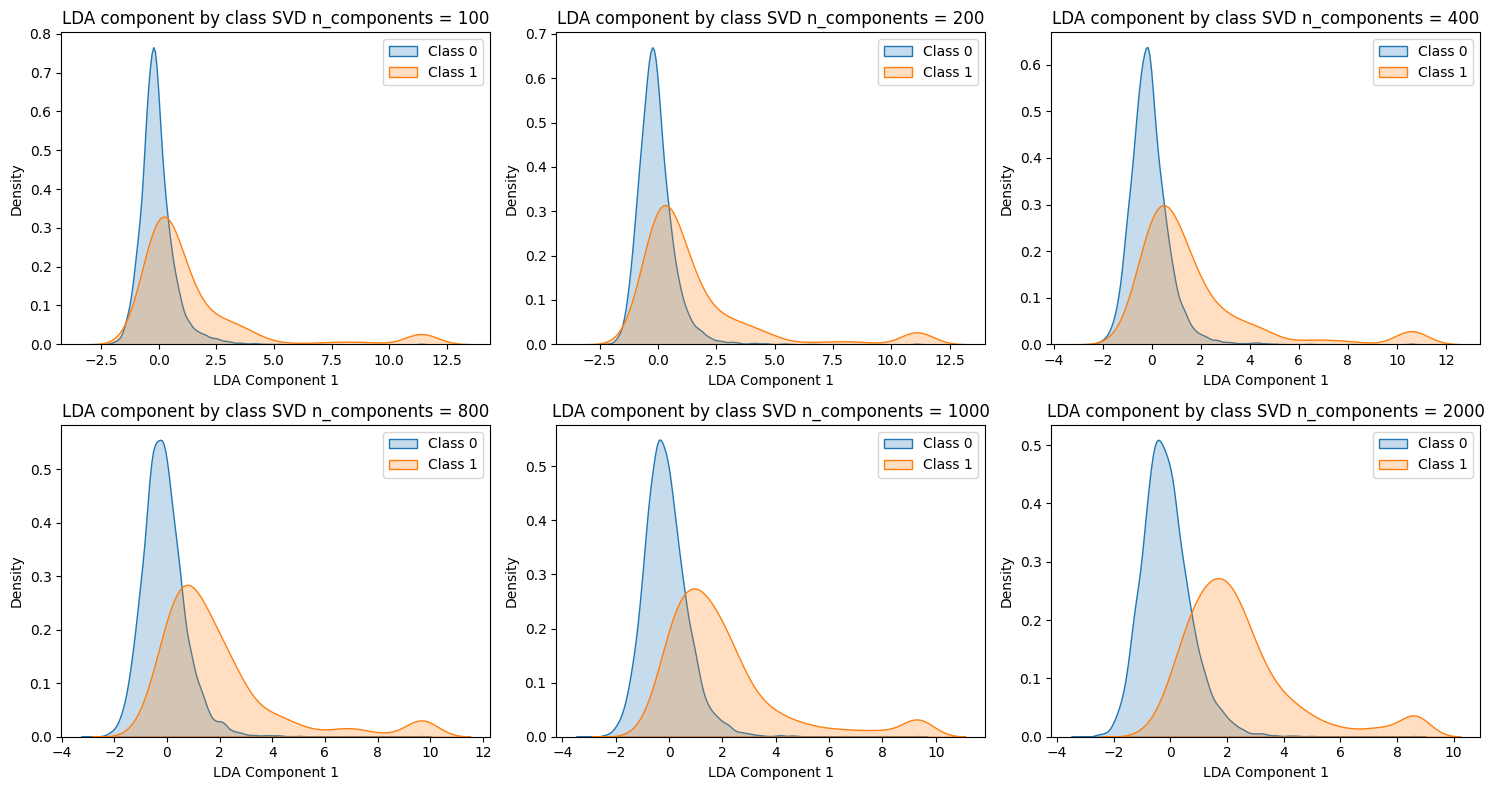

In [85]:
show_distribution_reduced_dimensions(X_clean, y_clean)

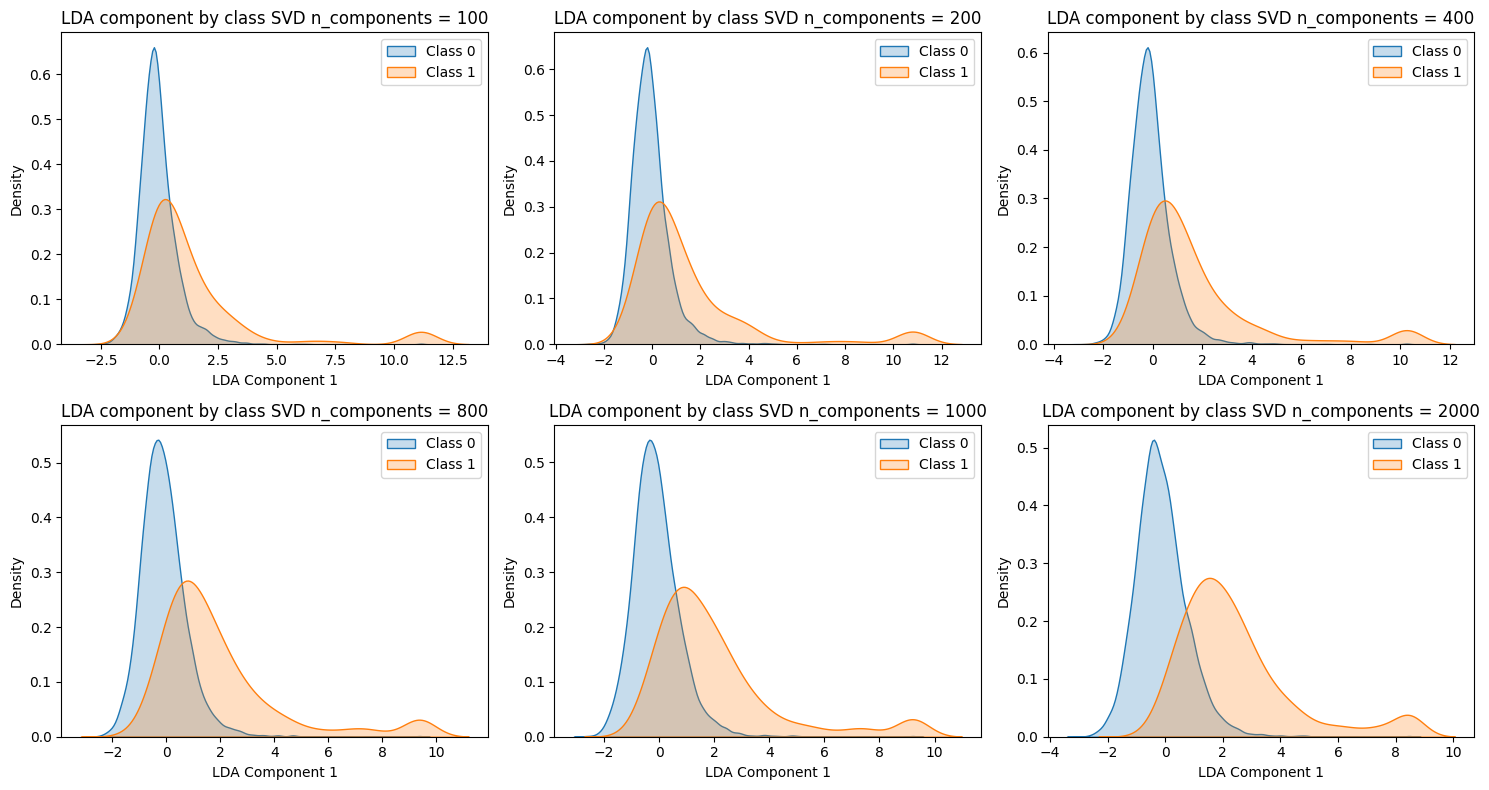

In [86]:
show_distribution_reduced_dimensions(X_stem_tok, y_stem_tok)

Further explore with the tokenized and stemmed dataset, as this seems to hold the same information with less features.

In [92]:
def get_outliers(X, n_components=50, n_neighbors=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X)
    X_2d_tsne = TSNE(n_components=2, random_state=42, perplexity=50).fit_transform(X_reduced)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.05)
    y_pred_lof = lof.fit_predict(X_reduced)  # -1 = outlier
    # turn into 0 and 1
    return X_2d_tsne, y_pred_lof == -1

In [93]:
X_2d_tsne, outliers = get_outliers(X_stem_tok, 50, 50)

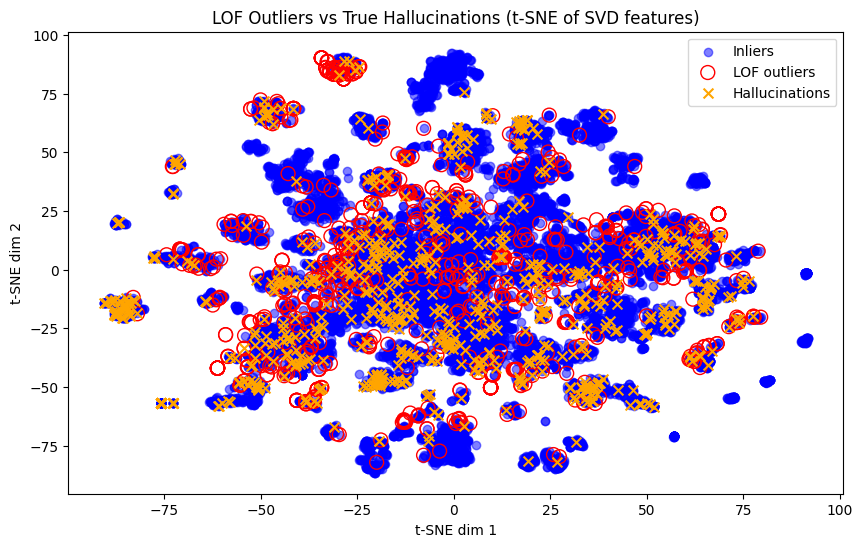

In [94]:
plt.figure(figsize=(10, 6))
# plot inliers
plt.scatter(X_2d_tsne[~outliers,0], X_2d_tsne[~outliers,1], 
            c='blue', alpha=0.5, label='Inliers')

# plot outliers detected by LOF
plt.scatter(X_2d_tsne[outliers,0], X_2d_tsne[outliers,1], 
            edgecolor='red', facecolor='none', s=100, label='LOF outliers')

# optionally highlight true hallucinations
hallucinations = (y == 1)
plt.scatter(X_2d_tsne[hallucinations,0], X_2d_tsne[hallucinations,1], 
            c='orange', marker='x', s=50, label='Hallucinations')

plt.legend()
plt.title('LOF Outliers vs True Hallucinations (t-SNE of SVD features)')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.show()

## Predictions with Outliers, LDA, Logistic Regression and BERT

### Predict with outlier detection

In [95]:
# Try to predict with Outlier detections
svd_dims = [100, 200, 400, 800, 1000, 2000]
results = []
for i, n in enumerate(svd_dims):
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_reduced = svd.fit_transform(X_stem_tok)
    lof = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
    outlier_labels = lof.fit_predict(X_reduced)  # -1 = outlier
    y_pred = (outlier_labels == -1).astype(int)

    results.append({
        "svd_components": n,
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred)
    })

results_df_lof = pd.DataFrame(results)
print(results_df_lof)

   svd_components  accuracy  precision    recall        f1
0             100  0.904353   0.041975  0.042131  0.042053
1             200  0.904600   0.044444  0.044610  0.044527
2             400  0.903983   0.038272  0.038414  0.038343
3             800  0.903118   0.029630  0.029740  0.029685
4            1000  0.902748   0.025926  0.026022  0.025974
5            2000  0.902501   0.023457  0.023544  0.023500


### Predict with LDA (After reducing dimensions with TruncatedSVD)

In [96]:
## Prediction models
svd_dims = [100, 200, 400, 800, 1000, 2000]
n_cols = 3
n_rows = (len(svd_dims) + n_cols - 1) // n_cols

# make stratified split on data to see prediction results of LDA
X_train, X_test, y_train, y_test = train_test_split(
    X_stem_tok, y_stem_tok, test_size=0.2, random_state=42, stratify=y_stem_tok
)

results = []

for i, n in enumerate(svd_dims):
    # SVD
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)

    # LDA classifier
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_svd, y_train)

    # Predictions
    y_pred = lda.predict(X_test_svd)
    y_prob = lda.predict_proba(X_test_svd)[:, 1]

    results.append({
        "svd_components": n,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print(results_df)

   svd_components  accuracy  precision    recall        f1   roc_auc
0             100  0.948750   0.450980  0.142857  0.216981  0.707872
1             200  0.947823   0.431034  0.155280  0.228311  0.719116
2             400  0.949058   0.468750  0.186335  0.266667  0.721735
3             800  0.943810   0.373494  0.192547  0.254098  0.718534
4            1000  0.947206   0.434211  0.204969  0.278481  0.716821
5            2000  0.943192   0.370787  0.204969  0.264000  0.712910


### Predict with Logistic Regression

First a quick test with some basic settings

{'accuracy': 0.8922506946588453, 'precision': 0.20063694267515925, 'recall': 0.391304347826087, 'f1': 0.26526315789473687}


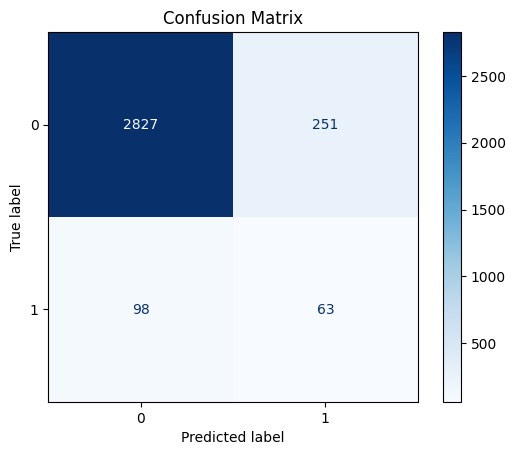

ROC-AUC: 0.7613730380702158


In [97]:
# split to training/test data
X_train, X_test, y_train, y_test = train_test_split(X_stem_tok, y_stem_tok, test_size=0.2, random_state=42, stratify=y_stem_tok)

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

results_lr = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr)
}
print(results_lr)
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])  # adjust labels as needed
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

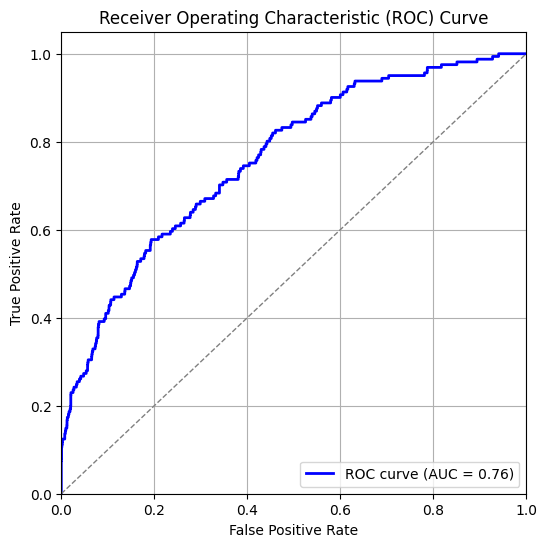

In [101]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve logistic regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Pipeline for LR hyperparameter tuning
- Looking at LR we can hypertune a few parameters:
    - using solver='saga' and l1_ratio=1 becomes slow, so we will look al l1_ratio=0 (L2) with solver='lbfgs'
    - class_weight='balanced' or None
    - C value. 0.1, 10, 50
- For TF-IDF there are different parameters as well:
    -  max_features as a maximum of how many features are stored, TF-IDF takes the "Most important" features
    -  min_df/max_df: minimum document_frequency and max document_frequency, how many times does a feature occur in the documents
    -  ngram_range: (1,1) takes just words, (1,2-99) takens bi-/tri-/etc-grams as well, resulting in more features, some maybe with more meaning than loose words.

We will focus on class_weight, C and max_features first:
- class_weight: balanced | None
- C: 0.1, 1, 10, 50 (A higher C reduces regularization in logistic regression, allowing the model to fit sparse or rare features more freely, which can improve performance on minority classes in imbalanced datasets.)
- max_features: 1000, 2000, 5000

Train model in stratified cross validation

In [151]:
def hyper_tuning(df, mf_values, c_values, ngram_range=[(1,1)]):
    X = df[['Prompt_clean', 'Answer_clean']]
    y = df['Target']
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    # ColumnTransformer to handle separate TF-IDF for each column
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf_prompt', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1), stop_words=stop_words, max_features=1000), 'Prompt_clean'),
            ('tfidf_answer', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1), stop_words=stop_words, max_features=1000), 'Answer_clean')
        ]
    )
    
    # Full pipeline
    pipeline = Pipeline([
        ('features', preprocessor),
        ('clf', LogisticRegression(l1_ratio=0, solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=42))
    ])
    
    # grid search for TF-IDF parameters and C
    param_grid = []
    for mf in mf_values:
        param_grid.append({
            'features__tfidf_prompt__ngram_range': ngram_range,
            'features__tfidf_answer__ngram_range': ngram_range,
            'features__tfidf_prompt__max_features': [mf],
            'features__tfidf_answer__max_features': [mf],
            'clf__class_weight': ['balanced', None],
            'clf__C': c_values
        })

    # Stratified K-Fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5, verbose=2)
    grid.fit(X_train, y_train)
    
    # Best parameters and F1
    print("Best params:", grid.best_params_)
    print("Best CV F1:", grid.best_score_)
    
    # Evaluate on test set
    y_pred = grid.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    print(f'Test scores, f1: {test_f1}, accuracy: {test_accuracy}, precision: {test_precision}, recall: {test_recall}')
    




In [110]:
hyper_tuning(df_stem_tok, [1000, 2000, 5000], [0.1, 1, 10, 50])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__C=0.1, clf__class_weight=balanced, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   0.9s
[CV] END clf__C=0.1, clf__class_weight=balanced, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   0.8s
[CV] END clf__C=0.1, clf__class_weight=balanced, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   0.8s
[CV] END clf__C=0.1, clf__class_weight=balanced, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   0.8s
[CV] END clf__C=0.1, clf__class_weight=balanced, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   0.8s
[CV] END clf__C=0.1, clf__class_weight=None, features__tfidf_answer__max_features=1000, features__tfidf_prompt__max_features=1000; total time=   1.0s
[CV] END clf__C=0.

In [111]:
hyper_tuning(df_stem_tok, [5000, 10000], [0.01, 1, 100])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   1.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   0.8s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   0.8s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   0.8s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   0.8s
[CV] END clf__C=0.01, clf__class_weight=None, features__tfidf_answer__max_features=5000, features__tfidf_prompt__max_features=5000; total time=   0.8s
[CV] END clf_

In [150]:
hyper_tuning(df_stem_tok, [5000, 10000], [0.01, 1, 100], [(2,2)])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_answer__ngram_range=(2, 2), features__tfidf_prompt__max_features=5000, features__tfidf_prompt__ngram_range=(2, 2); total time=   2.7s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_answer__ngram_range=(2, 2), features__tfidf_prompt__max_features=5000, features__tfidf_prompt__ngram_range=(2, 2); total time=   2.4s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_answer__ngram_range=(2, 2), features__tfidf_prompt__max_features=5000, features__tfidf_prompt__ngram_range=(2, 2); total time=   2.4s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=5000, features__tfidf_answer__ngram_range=(2, 2), features__tfidf_prompt__max_features=5000, features__tfidf_prompt__ngram_

In [152]:
hyper_tuning(df_stem_tok, [2000, 5000, 10000], [0.01, 1, 100], [(3,3)])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=2000, features__tfidf_answer__ngram_range=(3, 3), features__tfidf_prompt__max_features=2000, features__tfidf_prompt__ngram_range=(3, 3); total time=   2.7s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=2000, features__tfidf_answer__ngram_range=(3, 3), features__tfidf_prompt__max_features=2000, features__tfidf_prompt__ngram_range=(3, 3); total time=   3.7s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=2000, features__tfidf_answer__ngram_range=(3, 3), features__tfidf_prompt__max_features=2000, features__tfidf_prompt__ngram_range=(3, 3); total time=   2.8s
[CV] END clf__C=0.01, clf__class_weight=balanced, features__tfidf_answer__max_features=2000, features__tfidf_answer__ngram_range=(3, 3), features__tfidf_prompt__max_features=2000, features__tfidf_prompt__ngram_

In [117]:
# repeat with best params
# Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'features__tfidf_answer__max_features': 10000, 'features__tfidf_prompt__max_features': 10000, 'features__tfidf_answer__ngram_range': (1,1), 'features__tfidf_prompt__ngram_range': (1,1)}
accuracies = []
precisions = []
recalls = []
f1s = []

for seed in range(20):
# Split dataset
    X_train, X_test, y_train, y_test = train_test_split(df_stem_tok[['Prompt_clean', 'Answer_clean']], df_stem_tok['Target'], stratify=df_stem_tok['Target'], test_size=0.2, random_state=seed)
    
    # ColumnTransformer to handle separate TF-IDF for each column
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf_prompt', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1), stop_words=stop_words, max_features=10000), 'Prompt_clean'),
            ('tfidf_answer', TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,1), stop_words=stop_words, max_features=10000), 'Answer_clean')
        ]
    )
    
    # Full pipeline
    pipeline = Pipeline([
        ('features', preprocessor),
        ('clf', LogisticRegression(C=1, l1_ratio=0, solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=seed))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

print(f'avg f1: {np.mean(f1s)}, avg accuracy: {np.mean(accuracies)}, avg precisions: {np.mean(precisions)}, avg recalls: {np.mean(recalls)}')
print(f'std f1: {np.std(f1s)}, std accuracy: {np.std(accuracies)}, std precisions: {np.std(precisions)}, std recalls: {np.std(recalls)}')


avg f1: 0.24746379782769284, avg accuracy: 0.8884069157147267, avg precisions: 0.18629627031433293, avg recalls: 0.3692546583850932
std f1: 0.01648069002731244, std accuracy: 0.004731316736024876, std precisions: 0.012534838425528652, std recalls: 0.0296238132215863


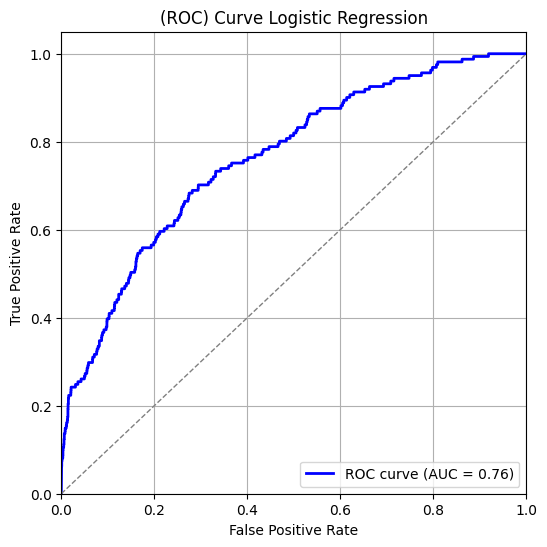

In [122]:
y_proba_lr = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

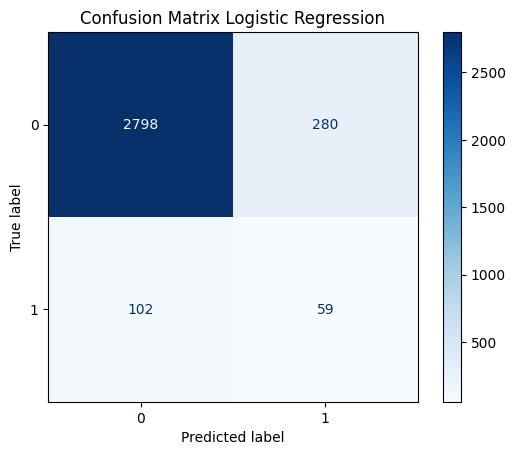

In [123]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Logistic Regression")
plt.show()

### Explain

In [125]:
# classifier
clf = pipeline.named_steps['clf']

# preprocessor
preprocessor = pipeline.named_steps['features']

In [126]:
# get tf-idf vectorizers
prompt_vectorizer = preprocessor.named_transformers_['tfidf_prompt']
answer_vectorizer = preprocessor.named_transformers_['tfidf_answer']

# get feature names
prompt_features = prompt_vectorizer.get_feature_names_out()
answer_features = answer_vectorizer.get_feature_names_out()

# Prefix to preserve origin
prompt_features = [f"PROMPT::{f}" for f in prompt_features]
answer_features = [f"ANSWER::{f}" for f in answer_features]

# combine
feature_names = np.concatenate([prompt_features, answer_features])

In [127]:
# get coefficients from model
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]

In [128]:
assert len(coefficients) == len(feature_names)

In [142]:
def get_explanation(id):
    x_sample = X_test.iloc[[id]]
    x_tfidf = preprocessor.transform(x_sample)
    x_tfidf = x_tfidf.toarray()[0]
    contributions = x_tfidf * coefficients

    # convert to dataframe
    explanation = pd.DataFrame({
        "feature": feature_names,
        "tfidf": x_tfidf,
        "coefficient": coefficients,
        "contribution": contributions
    })
    
    # Keep only active features
    explanation = explanation[explanation["tfidf"] > 0]
    
    # Sort by absolute contribution
    explanation = explanation.reindex(
        explanation.contribution.abs().sort_values(ascending=False).index
    )

    # show explanations:
    print(explanation.head(10))

In [143]:
# Try it out:
for i in range(10):
    get_explanation(i)
    print()

                feature     tfidf  coefficient  contribution
9161         ANSWER::ye  1.000000     0.656808      0.656808
3507      PROMPT::music  0.337905     0.995988      0.336550
3980       PROMPT::play  0.281323     0.796368      0.224036
225      PROMPT::answer  0.089362    -2.023485     -0.180823
3301       PROMPT::mean  0.135471    -1.098846     -0.148862
4717    PROMPT::sentenc  0.098786    -1.445527     -0.142797
3936       PROMPT::pick  0.148372    -0.852981     -0.126558
5274       PROMPT::task  0.058347     1.670363      0.097460
5924         PROMPT::ye  0.112034    -0.810122     -0.090761
634   PROMPT::brazilian  0.825459     0.057471      0.047440

              feature     tfidf  coefficient  contribution
7851      ANSWER::neg  1.000000    -1.140058     -1.140058
5075    PROMPT::stock  0.335698     0.698310      0.234422
4464   PROMPT::review  0.209168     1.092277      0.228469
3963    PROMPT::place  0.095652     1.943047      0.185856
238     PROMPT::anyon  0.155710  

,feature,tfidf,coefficient,contribution
9161,ANSWER::ye,1.000000,0.656808,0.656808
3507,PROMPT::music,0.337905,0.995988,0.336550
3980,PROMPT::play,0.281323,0.796368,0.224036
225,PROMPT::answer,0.089362,-2.023485,-0.180823
3301,PROMPT::mean,0.135471,-1.098846,-0.148862
4717,PROMPT::sentenc,0.098786,-1.445527,-0.142797
3936,PROMPT::pick,0.148372,-0.852981,-0.126558
5274,PROMPT::task,0.058347,1.670363,0.097460
5924,PROMPT::ye,0.112034,-0.810122,-0.090761
634,PROMPT::brazilian,0.825459,0.057471,0.047440
